In [1]:
import pandas as pd
import pickle
import lightgbm as lgb
import glob
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import time
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import datetime
from sklearn.linear_model import Ridge, LinearRegression

In [2]:
# reduce memory usage
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

Load modified alter + alphas_066 + labels (openclose_pct1_rank) data

In [7]:
print('========LOADING DATA========')
df_500 = pd.read_csv('pct1_cal/modified_alter_alphas_066_labels_500.csv')
print(df_500.shape)
print('========COMPLETE LOADING DATA========')

========LOADING DATA========
(569537, 293)
========COMPLETE LOADING DATA========


In [8]:
print('========LOADING DATA========')
df_1000 = pd.read_csv('pct1_cal/modified_alter_alphas_066_labels_1000.csv')
print(df_1000.shape)
print('========COMPLETE LOADING DATA========')

========LOADING DATA========
(1043552, 293)
========COMPLETE LOADING DATA========


In [3]:
print('========LOADING DATA========')
df_full = pd.read_csv('pct1_cal/modified_alter_alphas_066_labels.csv')
print(df_full.shape)
print('========COMPLETE LOADING DATA========')

========LOADING DATA========
(4599542, 293)
========COMPLETE LOADING DATA========


标准化openclose_pct1

中证500 股票ticker

In [ ]:
import uqer
from uqer import DataAPI   #优矿api
client = uqer.Client(token='18266a7c0ac9f8cdbe00f9b2ecb65f42316a5f78d9cc22ebabcbd923593356e4')
all_data = DataAPI.IdxConsCoreGet(secID=u"",ticker=u"000905",intoDate=u"",outDate=u"",field=u"",pandas="1")

In [ ]:
all_data['consTickerSymbol'] = all_data['consTickerSymbol'].astype(int)
tickers_500 = all_data.consTickerSymbol.sort_values().unique()
print(tickers_500.shape)

In [ ]:
df_500 = df1[df1.ticker.apply(lambda x: x in tickers_500)]
df_500.to_csv('pct1_cal/modified_alter_alphas_066_labels_500.csv', index=False)
print(df_500.shape)

中证1000 股票ticker

In [ ]:
import uqer
from uqer import DataAPI   #优矿api
client = uqer.Client(token='18266a7c0ac9f8cdbe00f9b2ecb65f42316a5f78d9cc22ebabcbd923593356e4')

In [ ]:
all_data = DataAPI.IdxConsGet(secID=u"",ticker=u"000852",isNew=u"",intoDate=u"",field=u"",pandas="1")

In [ ]:
all_data['consTickerSymbol'] = all_data['consTickerSymbol'].astype(int)
tickers_1000 = all_data.consTickerSymbol.sort_values().unique()
print(tickers_1000.shape)

In [ ]:
print('========LOADING DATA========')
df1 = pd.read_csv('pct1_cal/alter_idst_alphas_066_labels_raw.csv')
print(df1)
print('========COMPLETE LOADING DATA========')

In [ ]:
df_1000 = df1[df1.ticker.apply(lambda x: x in tickers_1000)]
df_1000.to_csv('pct1_cal/alter_idst_alphas_066_labels_raw_1000.csv', index=False)
print(df_1000)

Train ZZ500 with different models

In [4]:
df = df_full

In [5]:
del df_full

In [11]:
import matplotlib.pyplot as plt

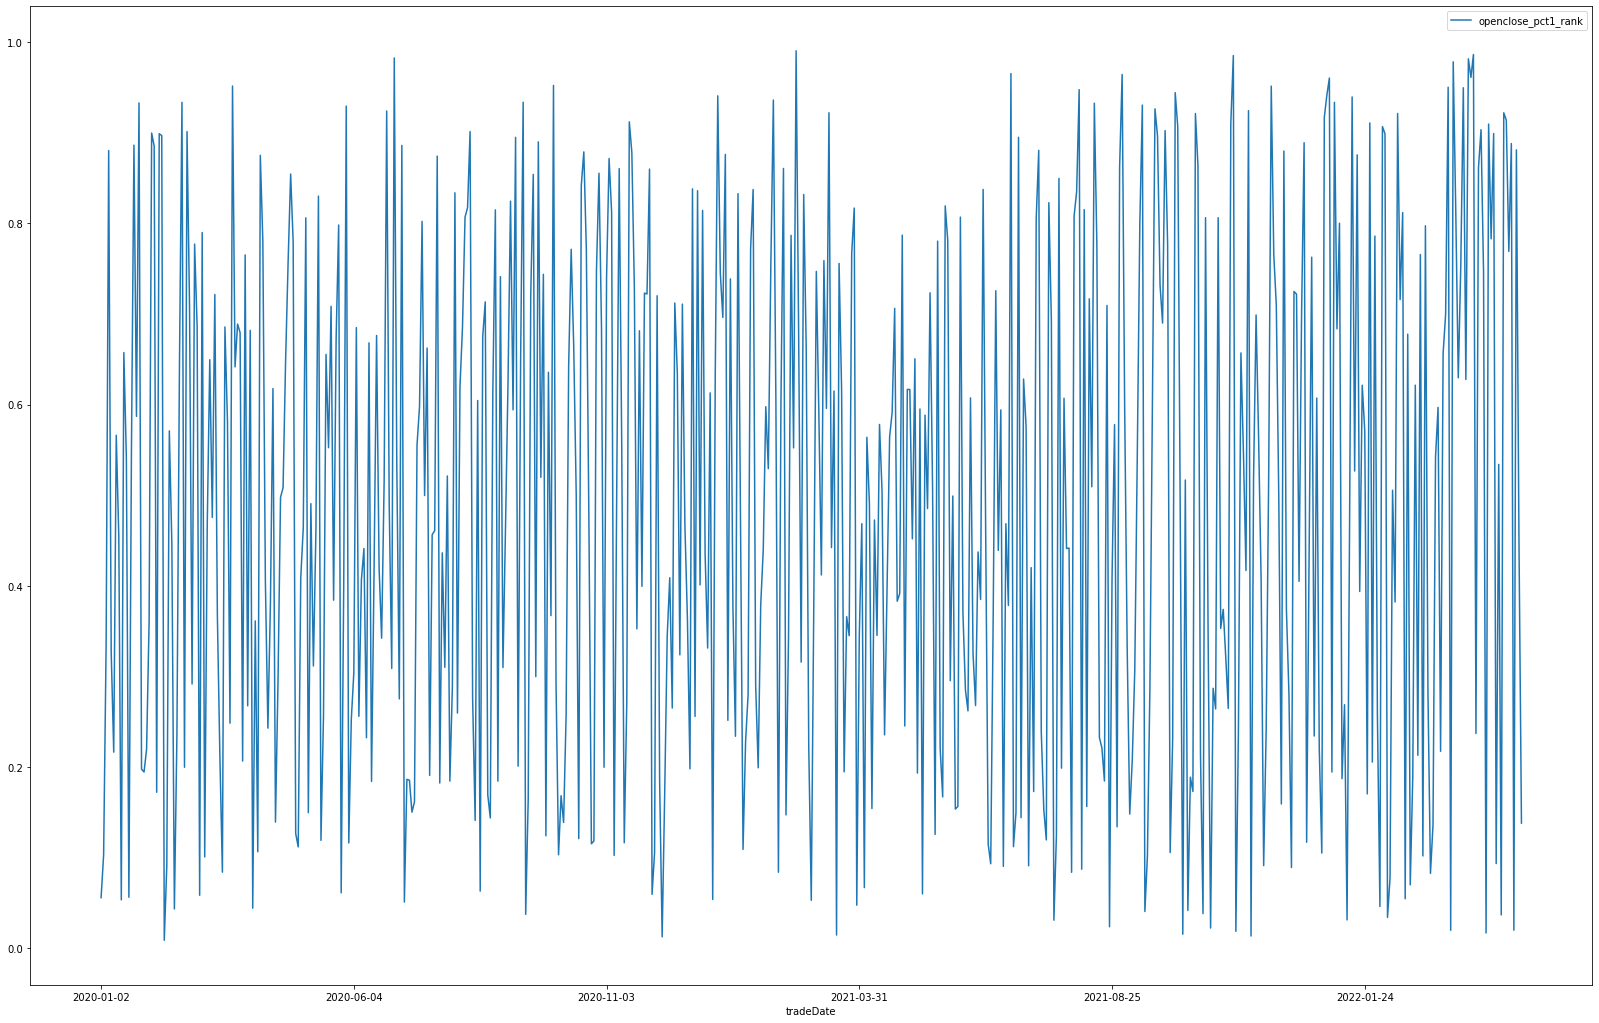

In [21]:
ax = plt.gca()
openclose[(openclose.ticker == 2) & (openclose.tradeDate > '2020-01-01')].plot(kind='line', x = 'tradeDate', y = 'openclose_pct1_rank', ax=ax, figsize=(28,18))
plt.legend()

In [6]:
dates = df.tradeDate.sort_values().unique()
epoch_ts = list(dates)

f_index = ['ticker', 'tradeDate']
f_x = pickle.load(open("pct1_cal/f_x_066", "rb"))
label_list = ['PCT5_rank', 'PCT2_rank', 'openclose_pct1_rank', 'askbid_pct1_rank']
f_y = label_list[2]

best_parameters_list = {} 
data_source = 'full_Alter_066_full'
file_location = 'pct1_cal'
file_type = 'full'
model_list = ['LinearRegression', 'RidgeR', 'DecisionTreeR', 'XGBoostR', 'LGBMRegressor']
model_name = model_list[4]

print('======== LEN_TRAIN {} ========'.format(f_y))
target_types = ['r', 'c'] # 分类问题还是回归问题 r 回归问题 c 分类问题
target_type = target_types[0]

result_name = '{}_{}_{}_{}'.format(data_source, model_name, f_y, target_type)
print(result_name)

update = 5 # 训练长度：22天
train_si = epoch_ts.index('2017-01-03') # included. '2017-01-03'
train_ei = epoch_ts.index('2019-01-02') # excluded. '2018-12-28'
test_si = epoch_ts.index('2019-01-02') # included. '2019-01-02'
test_ei = epoch_ts.index('2019-01-09') # excluded. '2019-01-31' '2019-01-09' '2019-01-16' '2019-02-01'
test_fi = len(epoch_ts) - 1 # excluded.

# number of epochs，循环次数
num_epoch = round((test_fi - test_ei) / update)
epoch_range = range(0, num_epoch + 1)

start = time.time()
df_result_all = pd.DataFrame()
total_IC = 0
i_range = list(np.arange(0, 1, 0.1)) + list(np.arange(0, 20, 1)) + [30, 40, 100, 200, 300]
timediff = pd.Timedelta(100,unit='d')
for epoch in epoch_range:
    best_df_result = pd.DataFrame()
    best_params = {}
    best_IC = 0
    print('----- EPOCH {}------'.format(epoch))
    update_n = epoch * update
    # get a list of train dates

    temp_addition = 0
    if epoch > 22:
        temp_addition = update_n

    epoch_t_train = epoch_ts[train_si + temp_addition : train_ei + update_n]
    # get a list of test dates
    epoch_t_test = epoch_ts[test_si + update_n : test_ei + update_n]
    df_train = df[df.tradeDate.apply(lambda x: x in epoch_t_train)].reset_index(drop=True)
    df_test = df[df.tradeDate.apply(lambda x: x in epoch_t_test)].reset_index(drop=True)
    print('预测时间：', epoch_t_test)
    print('数据大小：', df_train.shape, df_test.shape)

    a = pd.to_datetime(df_train.tradeDate)
    b = pd.to_datetime(df_train.listData)
    df_train = df_train[a-b > timediff]
    a = pd.to_datetime(df_test.tradeDate)
    b = pd.to_datetime(df_test.listData)
    df_test = df_test[a-b > timediff]

    # 获得 x
    x_train = df_train[f_x].values
    x_test = df_test[f_x].values

    # 获得y
    y_train = df_train[f_y].copy()
    y_test = df_test[f_y].copy()
    #print('y: ', y_train.shape, y_test.shape)
    
    if model_name == 'LinearRegression':
        model = LinearRegression(n_jobs=-1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
    elif model_name=='RidgeR': 
        for i in i_range:
            params = {
                    'alpha': i 
                }
            model = Ridge(**params)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            # print('get result')
            df_result = df_test[f_index].copy()
            df_result['y'] = y_test
            df_result['y_pred'] = y_pred
            # print(df_result)
            IC = df_result[['y', 'y_pred']].corr().iloc[0, 1]
            #print(IC)
            if best_IC < IC:
                best_IC = IC
                best_params = params
                best_df_result = df_result.copy()
    elif model_name=='DecisionTreeR': 
    # 'splitter': 'random', 'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 51
        from sklearn.tree import DecisionTreeRegressor
        model = DecisionTreeRegressor(splitter = 'random', criterion = 'friedman_mse', \
            max_depth = 5, min_samples_leaf = 51)
        model.fit(x_train, y_train)
    elif model_name == 'XGBoostR': 
    # 'n_estimators': 863, 'learning_rate': 0.014227661528235312, 
    # 'subsample': 0.6801233491797727, 'max_depth': 6
    # 0.106137
        from xgboost import XGBRegressor
        model = XGBRegressor(n_estimators=863, max_depth=6, learning_rate = 0.0142, subsample = 0.68)
        model.fit(x_train, y_train)
    elif model_name=='LGBMRegressor':
        #model = lgb.LGBMRegressor(max_depth=6, num_leaves=20, learning_rate=0.1, n_estimators=100)
        model = lgb.LGBMRegressor(max_depth=5, num_leaves=10, learning_rate=0.09, n_estimators=100)
        #model = lgb.LGBMRegressor(verbose=-1,
        #                num_leaves= 15,
        #                n_estimators=100,
        #                importance_type='gain',
        #                subsample= 0.9, 
        #                subsample_freq=2,
        #                min_child_samples=200,
        #                max_bin= 256,
        #                n_jobs=-1)
        model.fit(x_train, y_train, eval_set=[(x_train,y_train), (x_test,y_test)], eval_metric='l2')
        """
        for max_depth in [4, 5, 6, 7]:
            for num_leaves in [20, 30, 40, 50, 60]:
                for learning_rate in [0.03, 0.05, 0.07, 0.9, 0.11, 0.13]:
                    #for min_child_samples in range(120, 180, 10):
                    #'min_child_samples': range(10, 210, 20),
                    #'subsample': [i/10.0 for i in range(7,10)], 
                    #'subsample_freq': range(1,10,1)
                    params = {
                        'max_depth': max_depth,
                        'num_leaves': num_leaves, 
                        'learning_rate': learning_rate
                    }
                    gbm = lgb.LGBMRegressor(
                        **params,
                        verbose=-1,
                        objective = 'regression',
                        n_estimators=100,
                        metrics='rmse',
                        subsample= 0.9, 
                        subsample_freq=2,
                        min_child_samples=150,
                        max_bin= 256,
                        n_jobs=-1
                        )
                    gbm.fit(x_train, y_train)
                    y_pred = gbm.predict(x_test)
                    #print('get result')
                    df_result = df_test[f_index].copy()
                    df_result['y'] = y_test
                    df_result['y_pred'] = y_pred
                    #print(df_result)
                    IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
                    #print(IC)
                    if best_IC < IC:
                        best_IC = IC
                        best_params = params
                        best_df_result = df_result.copy()
        """
    y_pred = model.predict(x_test)
        #print(IC)
    #print('========BEST RESULT========')
    #print(best_params)
    #print(best_IC)
    #best_parameters_list[epoch] = [best_params, best_IC]

    # 获得结果
    print(f'耗时:{time.time() - start}')
    print('get result')
    df_result = df_test[f_index].copy()
    df_result['y'] = y_test
    df_result['y_pred'] = y_pred
    IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
    print(IC)
    total_IC += IC
    df_result_all = df_result_all.append(df_result)

print(f'耗时:{time.time() - start}') 
print('sort values')
df_result_all = df_result_all.sort_values(by=['ticker', 'tradeDate']).reset_index(drop=True)
IC = total_IC / num_epoch
today = (datetime.datetime.now()).strftime("%Y-%m-%d:%H:%M:%S")
print('store data')
#pickle.dump(best_parameters_list, open('{}/{}/best_parameters_list_{}_{}'.format(file_location, file_type, today, IC), 'wb'))
df_result_all = reduce_mem_usage(df_result_all)
df_result_all.to_csv('{}/{}/{}{}_{}.csv'.format(file_location, file_type, result_name, today, round(IC, 4)), index=False)
print('======== COMPLETE {} {} ========'.format(model_name, IC))

======== LEN_TRAIN openclose_pct1_rank ========
full_Alter_066_full_LGBMRegressor_openclose_pct1_rank_r
----- EPOCH 0------
预测时间： ['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08']
数据大小： (1513099, 293) (17621, 293)
[1]	training's l2: 0.0824859	valid_1's l2: 0.0831138
[2]	training's l2: 0.0824548	valid_1's l2: 0.08308
[3]	training's l2: 0.082427	valid_1's l2: 0.0830529
[4]	training's l2: 0.0824024	valid_1's l2: 0.0830265
[5]	training's l2: 0.0823815	valid_1's l2: 0.0830066
[6]	training's l2: 0.0823601	valid_1's l2: 0.0829909
[7]	training's l2: 0.0823396	valid_1's l2: 0.0829691
[8]	training's l2: 0.0823224	valid_1's l2: 0.0829558
[9]	training's l2: 0.0823042	valid_1's l2: 0.0829365
[10]	training's l2: 0.0822871	valid_1's l2: 0.082934
[11]	training's l2: 0.082269	valid_1's l2: 0.0829201
[12]	training's l2: 0.0822517	valid_1's l2: 0.0829036
[13]	training's l2: 0.0822363	valid_1's l2: 0.0829015
[14]	training's l2: 0.0822196	valid_1's l2: 0.0828958
[15]	training's l2: 0.0

In [ ]:
import datetime
today = (datetime.datetime.now()).strftime("%Y-%m-%d:%H:%M:%S")
#print('store data')
df_result_all.to_csv('pct1_cal/ZZ500/{}{}_{}.csv'.format(result_name, today, '0.0432'), index=False)

Get X and Y

In [6]:
dates = df.tradeDate.sort_values().unique()
epoch_ts = list(dates)

f_index = ['ticker', 'tradeDate']
f_x = pickle.load(open("pct1_cal/f_x_066", "rb"))
f_y = 'openclose_pct1_rank'

update = 22 # 训练长度：22天
train_si = epoch_ts.index('2017-01-03') # included. '2017-01-03'
train_ei = epoch_ts.index('2019-01-02') # excluded. '2018-12-28'
test_si = epoch_ts.index('2019-01-02') # included. '2019-01-02'
test_ei = epoch_ts.index('2019-02-01') # excluded. '2019-01-31'
test_fi = len(epoch_ts) - 1 # excluded.

# number of epochs，循环次数
num_epoch = round((test_fi - test_ei) / 22)
#epoch_range = range(0, num_epoch + 1)
#epoch_range = range(0, 1)

start = time.time()
df_result_all = pd.DataFrame()

epoch_t_train = epoch_ts[train_si + 22: train_ei + 22]
epoch_t_test = epoch_ts[test_si + 22: test_ei + 22]
df_train = df[df.tradeDate.apply(lambda x: x in epoch_t_train)].reset_index(drop=True)
df_test = df[df.tradeDate.apply(lambda x: x in epoch_t_test)].reset_index(drop=True)
print('预测时间：', epoch_t_test)
print('数据大小：', df_train.shape, df_test.shape)

x_train = df_train[f_x].values
x_test = df_test[f_x].values
print('处理后x:', x_train.shape, x_test.shape)

# 获得y
y_train = df_train[f_y].copy()
y_test = df_test[f_y].copy()
print('处理后y:', y_train.shape, y_test.shape)

预测时间： ['2019-02-01', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11']
数据大小： (1531528, 293) (77876, 293)
处理后x: (1531528, 290) (77876, 290)
处理后y: (1531528,) (77876,)


In [ ]:
best_params = {}
best_IC = 0
for max_depth in [4, 5, 6, 7]:
    for num_leaves in [20, 30, 40, 50, 60]:
        for learning_rate in [0.01, 0.02, 0.05, 0.1, 0.15]:
            params = {
                'max_depth': max_depth,
                'num_leaves': num_leaves, 
                'learning_rate': learning_rate
            }
            gbm = lgb.LGBMRegressor(
                **params,
                verbose=-1,
                objective = 'regression',
                n_estimators=100,
                metrics='rmse',
                subsample= 0.9, 
                subsample_freq=2,
                min_child_samples=150,
                max_bin= 256,
                n_jobs=-1
                )
            gbm.fit(x_train, y_train)
            y_pred = gbm.predict(x_test)
            print('get result')
            df_result = df_test[f_index].copy()
            df_result['y'] = y_test
            df_result['y_pred'] = y_pred
            #print(df_result)
            IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
            print(IC)
            if best_IC < IC:
                best_IC = IC
                best_params = params
print(best_params)
print(best_IC)

Gridsearch

In [7]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
parameters = {
     'max_depth': [4, 5, 6, 7],#range(3,8,2), 
     'num_leaves': [20, 30, 40, 50, 60],#range(10, 170, 20), 
     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
     #'min_child_samples': range(10, 210, 20),
     #'subsample': [i/10.0 for i in range(6,10)], 
     #'subsample_freq': range(1,10,1)
}
gbm = lgb.LGBMRegressor( objective = 'regression',
                         learning_rate = 0.05,
                         num_leaves = 40,
                         n_estimators=100,
                         max_depth=6,
                         metrics='rmse',
                         subsample= 0.9, 
                         subsample_freq=2,
                         min_child_samples=150,
                         max_bin= 256,
                         n_jobs=-1)
# 有了gridsearch我们便不需要fit函数
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='neg_mean_squared_error',\
     cv=TimeSeriesSplit(n_splits=4, test_size=22), verbose=1, n_jobs=-1)
gsearch.fit(x_train, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [ ]:
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
y_pred = gsearch.predict(x_test)
print('get result')
df_result = df_test[f_index].copy()
df_result['y'] = y_test
df_result['y_pred'] = y_pred
print(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print(IC)

In [ ]:
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
model = lgb.LGBMRegressor( objective = 'regression',
                         learning_rate = 0.05,
                         num_leaves = 40,
                         n_estimators=100,
                         max_depth=6,
                         metrics='rmse',
                         subsample= 0.9, 
                         subsample_freq=2,
                         min_child_samples=150,
                         max_bin= 256,
                         n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('get result')
df_result = df_test[f_index].copy()
df_result['y'] = y_test
df_result['y_pred'] = y_pred
print(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print(IC)

Optuna

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0, 0.1) # 0.0005 0.0744
        #'splitter': trial.suggest_categorical('splitter', ['random', 'best']),
        #'criterion': trial.suggest_categorical('criterion', ['friedman_mse']),
        #"n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        #"learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        #"subsample": trial.suggest_float("subsample", 0.5, 1),
        #"max_depth": trial.suggest_int("max_depth", 3, 8),
        #'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 60)
    }
    # 'n_estimators': [20], 'max_depth': [3], 'max_features': [10], 'subsample': [1.0]},
    # 'splitter': ['random'], 'criterion': ['friedman_mse'], 'max_depth': [6], 'min_samples_leaf': [41], 'min_impurity_decrease': [0.5]
    #cv = TimeSeriesSplit(n_splits=5)

    #cv_scores = np.empty(5)

    # LGBM
    #for idx, (train_idx, test_idx) in enumerate(cv.split(df_train[f_x], df_train[f_y])):
    #    x_cv_train, x_cv_test = df_train[f_x].iloc[train_idx], df_train[f_x].iloc[test_idx]
    #    y_cv_train, y_cv_test = df_train[f_y][train_idx], df_train[f_y][test_idx]
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.linear_model import Ridge
    model = Ridge(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

        # 获得结果
    df_result = pd.DataFrame({'y' : y_test, 'y_pred': y_pred})
    IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
    #    cv_scores[idx] = df_result[['y', 'y_pred']].corr().iloc[0,1]
    return IC #np.mean(cv_scores)

In [ ]:
from xgboost import XGBRegressor
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
model = lgb.LGBMRegressor(max_depth=5, num_leaves=10, learning_rate=0.01, n_estimators=3200)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric='l2')
y_pred = model.predict(x_test)

    # 获得结果
df_result = pd.DataFrame({'y' : y_test, 'y_pred': y_pred})
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print(IC)

Ridge Regression

In [ ]:
# alpha: 200
from sklearn.linear_model import Ridge
model = Ridge(alpha=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 获得结果
print('get result')
df_result = df_test[f_index].copy()
df_result['y'] = y_test
df_result['y_pred'] = y_pred
#df_result_all = df_result_all.append(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print('======== COMPLETE {} ========'.format(IC))

DecisionTree Regressor

In [ ]:
# 'splitter': ['random'], 'criterion': ['friedman_mse'], 'max_depth': [6], 'min_samples_leaf': [41], 'min_impurity_decrease': [0.5]
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(splitter = 'random', criterion = 'friedman_mse', max_depth = 6, min_samples_leaf = 41, min_impurity_decrease = 0.5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 获得结果
print('get result')
df_result = df_test[f_index].copy()
df_result['y'] = y_test
df_result['y_pred'] = y_pred
#df_result_all = df_result_all.append(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print('======== COMPLETE {} ========'.format(IC))

Random Forest Regressor

In [ ]:
# 'n_estimators': [400], 'max_depth': [9], 'max_features': [29]
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=400, max_depth=9, max_features=29)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 获得结果
print('get result')
df_result = df_test[f_index].copy()
df_result['y'] = y_test
df_result['y_pred'] = y_pred
#df_result_all = df_result_all.append(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print('======== COMPLETE {} ========'.format(IC))

XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=20, max_depth=6, subsample = 1.0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 获得结果
print('get result')
df_result = df_test[f_index].copy()
df_result['y'] = y_test
df_result['y_pred'] = y_pred
#df_result_all = df_result_all.append(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print('======== COMPLETE {} ========'.format(IC))

Lightgdb Regressor

In [ ]:
# depth = 6, num_leaves = 25
model = lgb.LGBMRegressor(learning_rate=0.09, num_leaves = 25, max_depth=6)
model.fit(x_train, y_train, eval_set=[(x_train,y_train), (x_test,y_test)], eval_metric='l2')
y_pred = model.predict(x_test)

# 获得结果
print('get result')
#df_result = df_test[f_index].copy()
#df_result['y'] = y_test
#df_result['y_pred'] = y_pred
#df_result_all = df_result_all.append(df_result)
df_result = pd.DataFrame({'y' : y_test, 'y_pred': y_pred})
print(df_result)
IC = df_result[['y', 'y_pred']].corr().iloc[0,1]
print('======== COMPLETE {} ========'.format(IC))

In [ ]:
best_params = {}
params = {}

In [ ]:
from sklearn.linear_model import Ridge as MODEL
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
model_name = 'RidgeRegression'
best_params[model_name] = {}
params[model_name] = {}

In [ ]:
estimator = 'alpha'
x_axis = np.arange(0, 500, 50)
params[model_name][estimator] = x_axis
result = []
for i in x_axis:
    this_model = MODEL(alpha=i)
    result.append(cross_val_score(this_model, x_train, y_train, cv = TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error').mean())
print('best parameter is {}'.format(x_axis[result.index(max(result))]))
plt.figure(figsize=(20, 5))
plt.title('## Model {}  ##'.format(model_name))
plt.plot(x_axis, result, c="red", label=estimator)
plt.legend()
plt.show()

best_params[model_name][estimator] = x_axis[result.index(max(result))]

In [ ]:
cv = TimeSeriesSplit(n_splits=5)
scoring='neg_mean_squared_error'

In [ ]:
from sklearn.svm import SVR as MODEL
model_name='SVR'
best_params[model_name] = {}
params[model_name] = {}

In [ ]:
e_name = 'gamma' # estimator_name
params[model_name][e_name] = [*np.logspace(-10, 1, 20)]

axisx = params[model_name][e_name]
rs = []
for i in axisx:
    clf = MODEL(gamma=i)
    rs.append(cross_val_score(clf, x_train, y_train, cv=cv, scoring=scoring).mean())
print('best parameter is {}'.format(x_axis[result.index(max(result))]))
plt.figure(figsize=(20, 5))
plt.title('## {} {} ##'.format(model_name, e_name))
plt.plot(axisx, rs, c="red", label=e_name)
plt.legend()
# plt.savefig()
plt.show()

best_params[model_name][e_name] = axisx[rs.index(max(rs))]